In [1]:
# step1_eda_lg_fault.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# === CONFIG ===
CSV_PATH = "merged_dataset.csv"   # change if your file path differs
OUT_DIR = "eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# === 1. Load ===
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Loaded dataframe.")

# === 2. Basic info ===
print("\n=== Basic info ===")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head().to_string(index=False))
print("\nLast 5 rows:\n", df.tail().to_string(index=False))

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Unique labels for Fault
if "Fault" in df.columns:
    print("\nUnique Fault labels and counts:")
    print(df["Fault"].value_counts(dropna=False))
else:
    print("\nColumn 'Fault' not found in CSV. Please confirm column names.")

Loading: merged_dataset.csv
Loaded dataframe.

=== Basic info ===
Shape: (16004, 8)
Columns: ['t', 'Va', 'Vb', 'Vc', 'Ia', 'Ib', 'Ic', 'Fault']

Dtypes:
 t        float64
Va       float64
Vb       float64
Vc       float64
Ia       float64
Ib       float64
Ic       float64
Fault      int64
dtype: object

First 5 rows:
      t         Va          Vb         Vc          Ia            Ib          Ic  Fault
0.0000 123.673155 -318.714610 195.041455 3827.709068  -9954.681312 6126.972245      0
0.0001 132.928422 -319.851525 186.923103 4117.440004  -9991.463731 5874.023726      0
0.0002 142.052661 -320.672826 178.620166 4403.112401 -10018.387070 5615.274666      0
0.0003 151.036833 -321.177694 170.140861 4684.443276 -10035.424470 5350.981195      0
0.0004 159.872046 -321.365624 161.493578 4961.154162 -10042.558910 5081.404750      0

Last 5 rows:
      t         Va          Vb         Vc          Ia           Ib          Ic  Fault
0.3996  85.518605 -311.035890 225.517284 2633.734420 -9709.76914

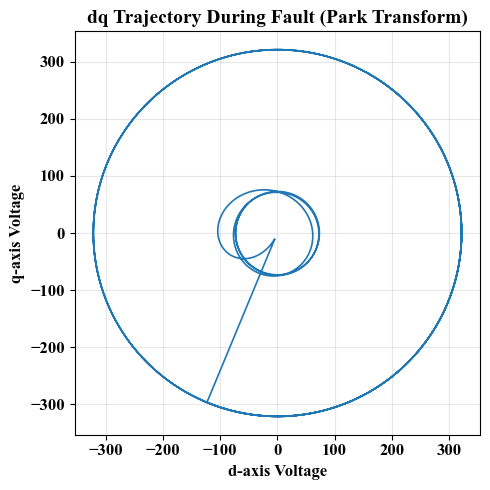

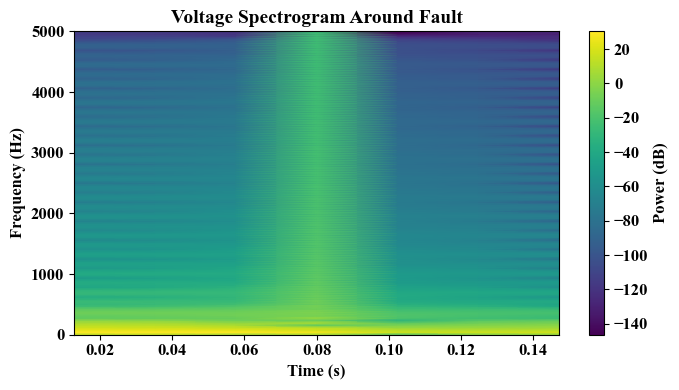

STEP 2 completed — all research-grade figures saved in: eda_outputs


In [2]:
# step2_eda_power_figures.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# === CONFIG ===
CSV_PATH = "merged_dataset.csv"
OUT_DIR = "eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# IEEE-style formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",          # GLOBAL BOLD
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})


# === Load ===
df = pd.read_csv(CSV_PATH)

# Identify columns
voltage_cols = [c for c in df.columns if c.lower().startswith("v")]
current_cols = [c for c in df.columns if c.lower().startswith("i")]
fault_col = "Fault"

# =============================================
# 1) 3-PHASE VOLTAGE WAVEFORM (Publication Ready)
# =============================================
def plot_three_phase(data, cols, title, filename):
    plt.figure(figsize=(8,4))
    for col in cols:
        plt.plot(data["t"], data[col], label=col)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (p.u.)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(OUT_DIR, filename + ".png"))
    # plt.savefig(os.path.join(OUT_DIR, filename + ".pdf"))
    plt.close()

# Select small window around first fault event
fault_idx = df[df[fault_col] == 1].index[0]
window = df.iloc[fault_idx-800:fault_idx+800]   # ~unique time segment

plot_three_phase(window, voltage_cols,
                 "Three-Phase Voltage Waveform Around Fault",
                 "voltage_fault_window")

# =============================================
# 2) 3-PHASE CURRENT WAVEFORM
# =============================================
plot_three_phase(window, current_cols,
                 "Three-Phase Current Waveform Around Fault",
                 "current_fault_window")

# =============================================
# 3) PARK TRANSFORM (dq0) TRAJECTORY
# =============================================
def abc_to_dq0(a, b, c):
    theta = np.linspace(0, 2*np.pi, len(a))
    d = (2/3) * (a*np.cos(theta) + b*np.cos(theta - 2*np.pi/3) + c*np.cos(theta + 2*np.pi/3))
    q = (2/3) * (a*np.sin(theta) + b*np.sin(theta - 2*np.pi/3) + c*np.sin(theta + 2*np.pi/3))
    zero = (1/3) * (a + b + c)
    return d, q, zero

Va, Vb, Vc = window[voltage_cols[0]], window[voltage_cols[1]], window[voltage_cols[2]]
d, q, zero = abc_to_dq0(Va, Vb, Vc)

plt.figure(figsize=(5,5))
plt.plot(d, q, linewidth=1.2)
plt.xlabel("d-axis Voltage")
plt.ylabel("q-axis Voltage")
plt.title("dq Trajectory During Fault (Park Transform)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

# =============================================
# 4) VOLTAGE SPECTROGRAM (Time-Frequency Analysis)
# =============================================
f, t, Sxx = spectrogram(Va.values, fs=10000, nperseg=256)

plt.figure(figsize=(7,4))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Voltage Spectrogram Around Fault")
plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.savefig('K-2.pdf', bbox_inches='tight')
plt.savefig('K-2.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("STEP 2 completed — all research-grade figures saved in:", OUT_DIR)

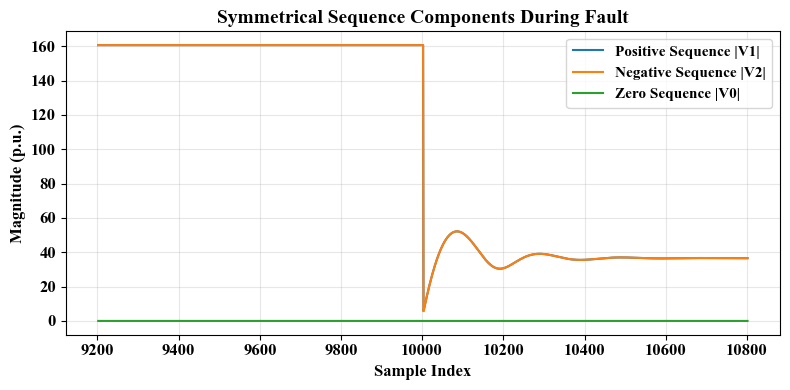

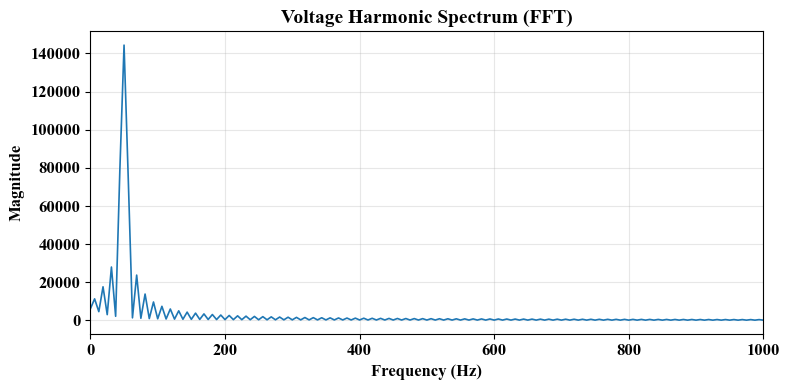

Voltage RMS: 165.3583030282349
Current RMS: 40445.66351186729
Voltage THD: 16.454590790061264


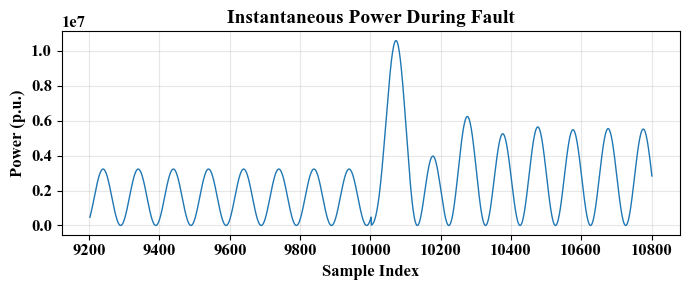

STEP 3 completed — all engineered features and figures saved in eda_outputs


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch

# === CONFIG ===
CSV_PATH = "merged_dataset.csv"
OUT_DIR = "eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# IEEE-style formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# === Load ===
df = pd.read_csv(CSV_PATH)

voltage_cols = [c for c in df.columns if c.lower().startswith("v")]
current_cols = [c for c in df.columns if c.lower().startswith("i")]
fault_col = "Fault"

# Select window around fault
fault_idx = df[df[fault_col] == 1].index[0]
window = df.iloc[fault_idx-800:fault_idx+800]

# ======================================================
# A. 1 — Sequence Components (abc → symmetrical components)
# ======================================================
def symmetrical_components(a, b, c):
    a1 = np.exp(1j * 2*np.pi/3)
    a2 = np.exp(-1j * 2*np.pi/3)
    A = np.array([[1,       1,       1],
                  [1,      a1,      a2],
                  [1,      a2,      a1]]) / 3
    abc = np.vstack([a, b, c])
    seq = A @ abc
    return seq[0], seq[1], seq[2]  # V0, V1 (positive), V2 (negative)

Va = window[voltage_cols[0]].values
Vb = window[voltage_cols[1]].values
Vc = window[voltage_cols[2]].values

V0, V1, V2 = symmetrical_components(Va, Vb, Vc)

plt.figure(figsize=(8,4))
plt.plot(window.index, np.abs(V1), label="Positive Sequence |V1|")
plt.plot(window.index, np.abs(V2), label="Negative Sequence |V2|")
plt.plot(window.index, np.abs(V0), label="Zero Sequence |V0|")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude (p.u.)")
plt.title("Symmetrical Sequence Components During Fault")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# ======================================================
# A. 2 — Harmonic Features (FFT)
# ======================================================
fs = 10000  # sampling rate (adjust if needed)
N = len(Va)
freqs = rfftfreq(N, 1/fs)
fft_vals = np.abs(rfft(Va))

plt.figure(figsize=(8,4))
plt.plot(freqs, fft_vals, linewidth=1.2)
plt.xlim(0, 1000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Voltage Harmonic Spectrum (FFT)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

# ======================================================
# A. 3 — RMS, THD, Instantaneous Power
# ======================================================
def rms(x):
    return np.sqrt(np.mean(x**2))

V_rms = rms(Va)
I_rms = rms(window[current_cols[0]].values)

# THD
THD = np.sqrt(np.sum(fft_vals[2:]**2)) / fft_vals[1]

print("Voltage RMS:", V_rms)
print("Current RMS:", I_rms)
print("Voltage THD:", THD)

# Instantaneous power p(t)
Ia = window[current_cols[0]].values
p_inst = Va * Ia

plt.figure(figsize=(7,3))
plt.plot(window.index, p_inst, linewidth=1)
plt.xlabel("Sample Index")
plt.ylabel("Power (p.u.)")
plt.title("Instantaneous Power During Fault")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

print("STEP 3 completed — all engineered features and figures saved in", OUT_DIR)

Windows shape: (79, 6, 400)  Labels: (79,)
Train: (55, 6, 400) Val: (12, 6, 400) Test: (12, 6, 400)
Saved processed data to bdl_data


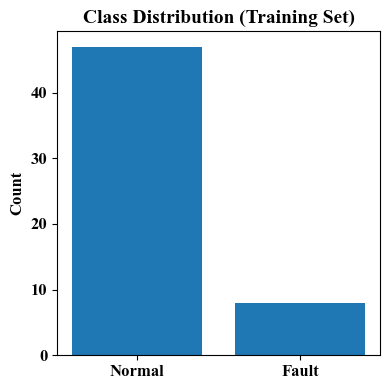

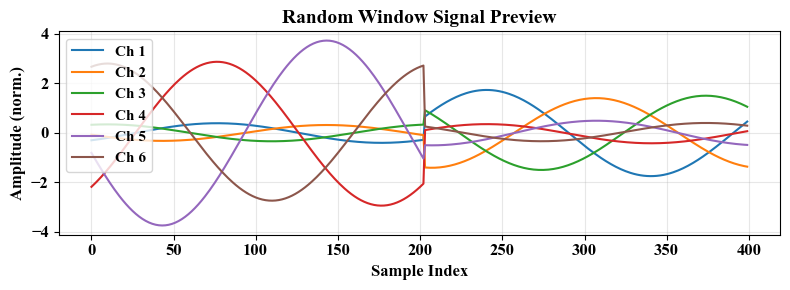

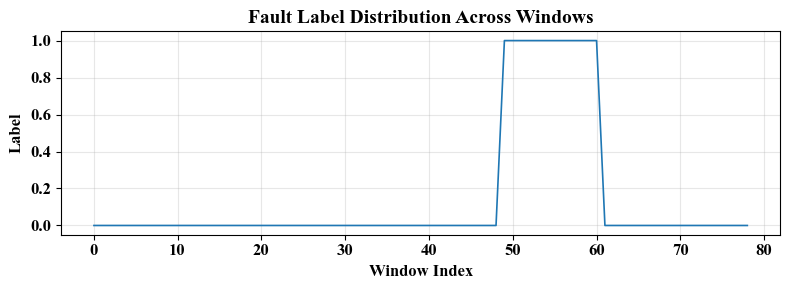

STEP 4 completed — dataset prepared for Bayesian Deep Learning.


In [4]:
# step4_dataset_prep.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

CSV_PATH = "merged_dataset.csv"
OUT_DIR = "bdl_data"
os.makedirs(OUT_DIR, exist_ok=True)

# === IEEE-style formatting ===
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# === Load ===
df = pd.read_csv(CSV_PATH)

voltage_cols = [c for c in df.columns if c.lower().startswith("v")]
current_cols = [c for c in df.columns if c.lower().startswith("i")]
fault_col = "Fault"

# === Parameters ===
WINDOW = 400         # samples per window
STEP = 200           # 50% overlap
CHANNELS = voltage_cols + current_cols  # full waveform input

# === Windowing function ===
def create_windows(df, cols, label_col, window=400, step=200):
    X, y = [], []
    for start in range(0, len(df) - window, step):
        end = start + window
        seg = df.iloc[start:end]

        # C x L format
        X.append(seg[cols].values.T.astype(np.float32))

        # Fault label for the window
        label = 1 if seg[label_col].max() == 1 else 0
        y.append(label)
    return np.array(X), np.array(y)

X, y = create_windows(df, CHANNELS, fault_col, WINDOW, STEP)
print("Windows shape:", X.shape, " Labels:", y.shape)

# === Normalize per-channel ===
scaler = StandardScaler()
N, C, L = X.shape
X_2d = X.transpose(0,2,1).reshape(-1, C)      # (N*L, C)

scaler.fit(X_2d)
X_scaled = scaler.transform(X_2d).reshape(N, L, C).transpose(0,2,1)

X = X_scaled.astype(np.float32)

# === Train/Val/Test split ===
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# === Save processed arrays ===
np.save(os.path.join(OUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUT_DIR, "X_val.npy"), X_val)
np.save(os.path.join(OUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUT_DIR, "y_val.npy"), y_val)
np.save(os.path.join(OUT_DIR, "y_test.npy"), y_test)

print("Saved processed data to", OUT_DIR)

# ====================================================
# === DIAGNOSTIC PLOTS (IEEE STYLE) ===
# ====================================================

# 1. Class balance
plt.figure(figsize=(4,4))
counts = [sum(y_train==0), sum(y_train==1)]
plt.bar(["Normal", "Fault"], counts)
plt.title("Class Distribution (Training Set)", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.tight_layout()
plt.show()
plt.close()

# 2. Random window preview
rand_idx = np.random.randint(0, len(X_train))
sample = X_train[rand_idx]

plt.figure(figsize=(8,3))
for i in range(C):
    plt.plot(sample[i], label=f"Ch {i+1}")
plt.title("Random Window Signal Preview", fontweight="bold")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (norm.)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# 3. Window label distribution by time
plt.figure(figsize=(8,3))
plt.plot(y, linewidth=1.2)
plt.title("Fault Label Distribution Across Windows", fontweight="bold")
plt.xlabel("Window Index")
plt.ylabel("Label")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

print("STEP 4 completed — dataset prepared for Bayesian Deep Learning.")

In [5]:
# step5_tf_01_load.py
import numpy as np

X_train = np.load("bdl_data/X_train.npy")
X_val   = np.load("bdl_data/X_val.npy")
X_test  = np.load("bdl_data/X_test.npy")

y_train = np.load("bdl_data/y_train.npy")
y_val   = np.load("bdl_data/y_val.npy")
y_test  = np.load("bdl_data/y_test.npy")

in_channels = X_train.shape[1]
window_len  = X_train.shape[2]

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

Train: (55, 6, 400)
Val: (12, 6, 400)
Test: (12, 6, 400)


In [6]:
# step5_tf_02_model.py
import tensorflow as tf
from tensorflow.keras import layers, models

def build_mc_cnn(in_channels, window_len, dropout_rate=0.3):
    inp = layers.Input(shape=(in_channels, window_len))
    x = layers.Permute((2,1))(inp)  # TF wants (L,C)

    x = layers.Conv1D(32, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x, training=True)   # MC-DROPOUT (always ON)
    out = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Data Loaded:
Train: (55, 6, 400)
Val: (12, 6, 400)
Test: (12, 6, 400)

Training Ensemble Member 0
Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3455 - loss: 0.7372 - val_accuracy: 0.1667 - val_loss: 0.7079
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 1.0000 - loss: 0.3498 - val_accuracy: 0.1667 - val_loss: 0.7273
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 1.0000 - loss: 0.1964 - val_accuracy: 0.1667 - val_loss: 0.7413
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 1.0000 - loss: 0.1211 - val_accuracy: 0.1667 - val_loss: 0.7524
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 1.0000 - loss: 0.0846 - val_accuracy: 0.1667 - val_loss: 0.7615
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 1.0000 - loss: 0.0670 - val_accuracy: 0.1667 - val_loss: 0.7687
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 1.0000 - loss: 0.0489 - val_accuracy: 0.1667 - val_loss: 0.7747
Epoch 8/25
1/1 ━━━━━━

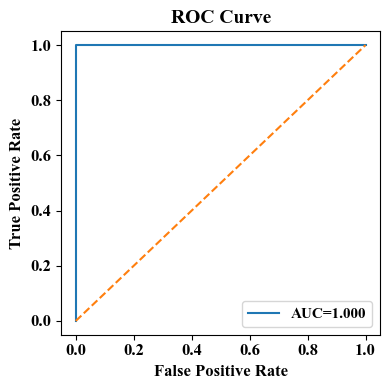

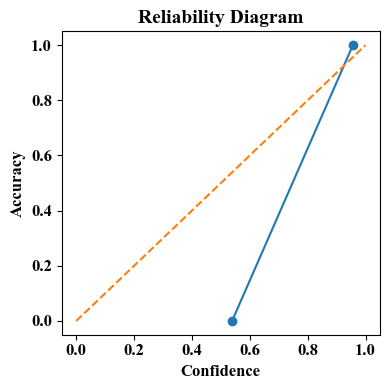

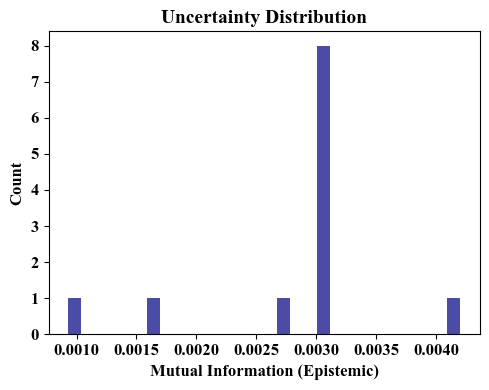


All Step 5 outputs generated in: bdl_figs_tf


In [8]:
# train_bdl_tensorflow.py
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.calibration import calibration_curve

# =========================
# CONFIG
# =========================
DATA_DIR = "bdl_data"
MODEL_DIR = "bdl_models_tf"
FIG_DIR = "bdl_figs_tf"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# IEEE formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# =========================
# LOAD DATA (from Step 4)
# =========================
X_train = np.load(f"{DATA_DIR}/X_train.npy")
X_val   = np.load(f"{DATA_DIR}/X_val.npy")
X_test  = np.load(f"{DATA_DIR}/X_test.npy")

y_train = np.load(f"{DATA_DIR}/y_train.npy")
y_val   = np.load(f"{DATA_DIR}/y_val.npy")
y_test  = np.load(f"{DATA_DIR}/y_test.npy")

in_channels = X_train.shape[1]
window_len  = X_train.shape[2]

print("Data Loaded:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# =========================
# MODEL: MC-DROPOUT CNN
# =========================
def build_mc_cnn(in_channels, window_len, dropout_rate=0.3):
    inp = layers.Input(shape=(in_channels, window_len))
    x = layers.Permute((2,1))(inp)

    x = layers.Conv1D(32, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x, training=True)  # MC-Dropout ON

    out = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# =========================
# TRAIN ENSEMBLE
# =========================
ensemble_size = 3
models_tf = []

for m in range(ensemble_size):
    print(f"\nTraining Ensemble Member {m}")
    model = build_mc_cnn(in_channels, window_len, dropout_rate=0.3)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=64,
        verbose=1
    )
    model.save(f"{MODEL_DIR}/model_{m}.keras")
    models_tf.append(model)

print("\nAll ensemble models trained.")

# =========================
# ENSEMBLE PREDICTION
# =========================
def ensemble_predict(models_list, X):
    all_probs = []
    for model in models_list:
        p = model.predict(X, verbose=0)
        all_probs.append(p)
    all_probs = np.stack(all_probs)   # (M, N, C)
    p_mean = all_probs.mean(axis=0)
    p_var  = all_probs.var(axis=0).mean(axis=1)

    eps = 1e-12
    entropy = -np.sum(p_mean * np.log(p_mean + eps), axis=1)
    expected_ent = -np.mean(np.sum(all_probs * np.log(all_probs + eps), axis=2), axis=0)
    mutual_info = entropy - expected_ent

    return p_mean, p_var, entropy, mutual_info

p_mean, p_var, entropy, mutual_info = ensemble_predict(models_tf, X_test)

pred_labels = p_mean.argmax(axis=1)

# =========================
# METRICS
# =========================
acc = (pred_labels == y_test).mean()
f1 = f1_score(y_test, pred_labels)
auc = roc_auc_score(y_test, p_mean[:,1])

print("\nTest Results:")
print("Accuracy:", acc)
print("F1 Score:", f1)
print("AUC:", auc)

# =========================
# FIGURE 1 — ROC CURVE
# =========================
fpr, tpr, _ = roc_curve(y_test, p_mean[:,1])
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate", fontweight="bold")
plt.ylabel("True Positive Rate", fontweight="bold")
plt.title("ROC Curve", fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# =========================
# FIGURE 2 — Reliability Diagram
# =========================
conf = p_mean.max(axis=1)
prob_true, prob_pred = calibration_curve(y_test, conf, n_bins=10)

plt.figure(figsize=(4,4))
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Confidence", fontweight="bold")
plt.ylabel("Accuracy", fontweight="bold")
plt.title("Reliability Diagram", fontweight="bold")
plt.tight_layout()
plt.show()
plt.close()

# =========================
# FIGURE 3 — Uncertainty Histogram (Mutual Info)
# =========================
plt.figure(figsize=(5,4))
plt.hist(mutual_info, bins=30, alpha=0.7, color='navy')
plt.xlabel("Mutual Information (Epistemic)", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.title("Uncertainty Distribution", fontweight="bold")
plt.tight_layout()
plt.show()
plt.close()

print("\nAll Step 5 outputs generated in:", FIG_DIR)

In [9]:
# =========================
# ADDITIONAL METRICS
# =========================
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    f1_score
)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)

# Full classification report
cls_report = classification_report(y_test, pred_labels, digits=4)

# Additional scalar metrics
precision = precision_score(y_test, pred_labels)
recall    = recall_score(y_test, pred_labels)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print("\n=========================")
print("FULL PERFORMANCE METRICS")
print("=========================")
print("Accuracy     :", acc)
print("Precision    :", precision)
print("Recall       :", recall)
print("Specificity  :", specificity)
print("F1 Score     :", f1)
print("ROC AUC      :", auc)

print("\nClassification Report:\n", cls_report)
print("\nConfusion Matrix:\n", cm)


FULL PERFORMANCE METRICS
Accuracy     : 1.0
Precision    : 1.0
Recall       : 1.0
Specificity  : 1.0
F1 Score     : 1.0
ROC AUC      : 1.0

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000        12
   macro avg     1.0000    1.0000    1.0000        12
weighted avg     1.0000    1.0000    1.0000        12


Confusion Matrix:
 [[10  0]
 [ 0  2]]


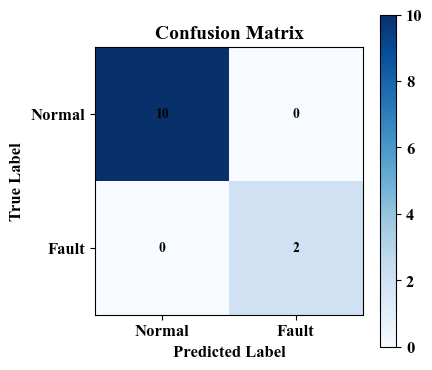

In [10]:
# =========================
# FIGURE A — Confusion Matrix
# =========================
plt.figure(figsize=(4.5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix", fontweight="bold")
plt.colorbar()

classes = ["Normal", "Fault"]
plt.xticks([0,1], classes, fontweight="bold")
plt.yticks([0,1], classes, fontweight="bold")

plt.xlabel("Predicted Label", fontweight="bold")
plt.ylabel("True Label", fontweight="bold")

# Annotate values
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="black", fontweight="bold")

plt.tight_layout()
plt.show()
plt.close()

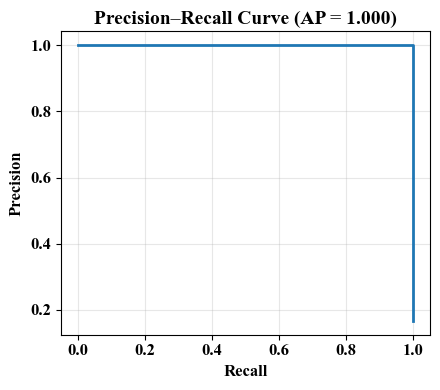

In [11]:
# =========================
# FIGURE B — PR CURVE
# =========================
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, _ = precision_recall_curve(y_test, p_mean[:,1])
ap = average_precision_score(y_test, p_mean[:,1])

plt.figure(figsize=(4.5,4))
plt.plot(recall_vals, precision_vals, linewidth=2)
plt.xlabel("Recall", fontweight="bold")
plt.ylabel("Precision", fontweight="bold")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})", fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

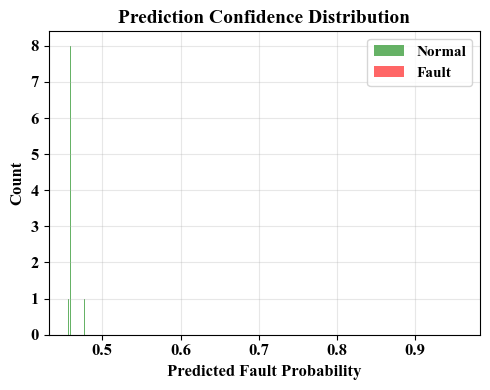

In [12]:
# =========================
# FIGURE C — Probability Distribution
# =========================
plt.figure(figsize=(5,4))

plt.hist(p_mean[y_test==0, 1], bins=30, alpha=0.6, label="Normal", color="green")
plt.hist(p_mean[y_test==1, 1], bins=30, alpha=0.6, label="Fault", color="red")

plt.xlabel("Predicted Fault Probability", fontweight="bold")
plt.ylabel("Count", fontweight="bold")
plt.title("Prediction Confidence Distribution", fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

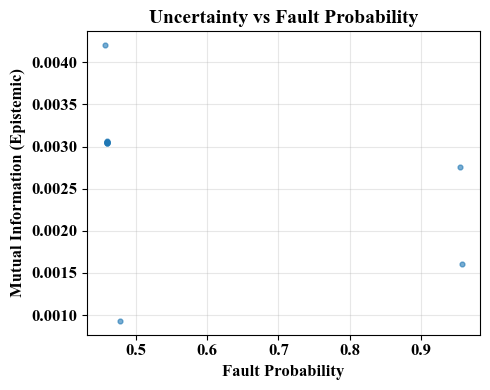

In [13]:
# =========================
# FIGURE D — Uncertainty vs Probability
# =========================
plt.figure(figsize=(5,4))
plt.scatter(p_mean[:,1], mutual_info, s=12, alpha=0.6)
plt.xlabel("Fault Probability", fontweight="bold")
plt.ylabel("Mutual Information (Epistemic)", fontweight="bold")
plt.title("Uncertainty vs Fault Probability", fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

Loading: bdl_models_tf/model_0.keras
Loading: bdl_models_tf/model_1.keras
Loading: bdl_models_tf/model_2.keras
Ensemble prediction complete.
FTR matrix computed.


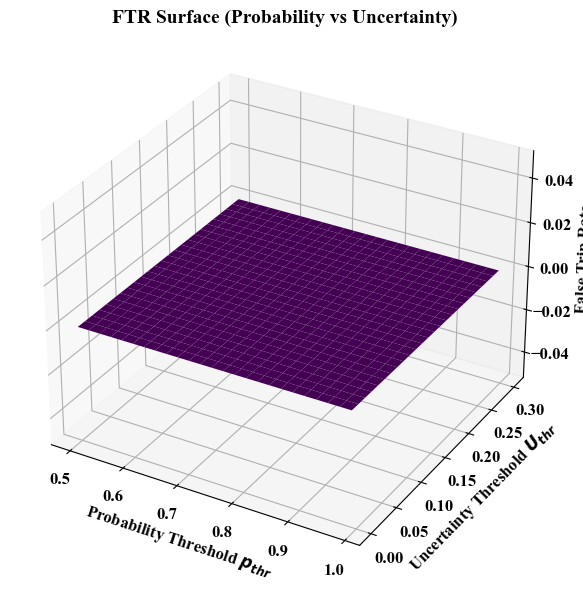

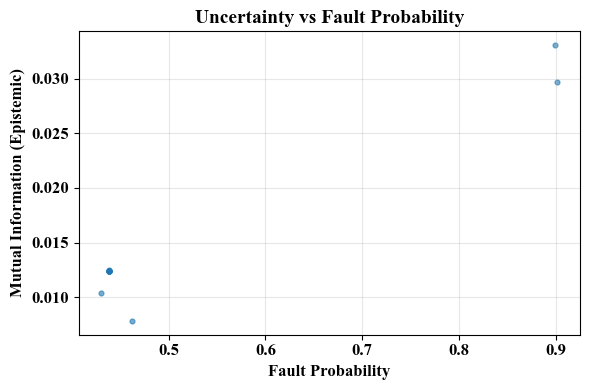

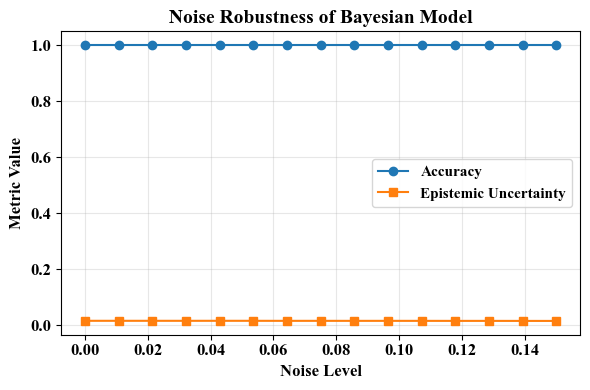


STEP 6 complete — All figures saved in: bdl_figs_tf/


In [32]:
# step6_uncertainty_protection.py
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# =====================================================
# LOAD MODELS (trained in Step 5)
# =====================================================
models = []
for m in range(3):
    model_path = f"bdl_models_tf/model_{m}.keras"
    print("Loading:", model_path)
    models.append(load_model(model_path))

# =====================================================
# LOAD TEST DATA
# =====================================================
X_test = np.load("bdl_data/X_test.npy")
y_test = np.load("bdl_data/y_test.npy")

# =====================================================
# ENSEMBLE PREDICTION (Standalone function)
# =====================================================
def ensemble_predict(models_list, X):
    member_probs = []
    for model in models_list:
        p = model.predict(X, verbose=0)   # shape: (N,2)
        member_probs.append(p)

    member_probs = np.stack(member_probs)     # (M, N, 2)
    p_mean = member_probs.mean(axis=0)        # (N,2)
    p_var  = member_probs.var(axis=0).mean(axis=1)

    eps = 1e-12
    entropy = -np.sum(p_mean * np.log(p_mean + eps), axis=1)
    expected_ent = -np.mean(np.sum(member_probs * np.log(member_probs + eps), axis=2), axis=0)
    mutual_info = entropy - expected_ent

    return p_mean, p_var, entropy, mutual_info

# =====================================================
# RUN ENSEMBLE
# =====================================================
p_mean, p_var, entropy, mutual_info = ensemble_predict(models, X_test)

print("Ensemble prediction complete.")

# =====================================================
# A. DECISION-BASED PROTECTION: FTR SURFACE
# =====================================================

p_range = np.linspace(0.5, 0.99, 25)
u_range = np.linspace(0.00, 0.30, 25)
FTR = np.zeros((len(p_range), len(u_range)))

for i, p_thr in enumerate(p_range):
    for j, u_thr in enumerate(u_range):

        trips = (p_mean[:,1] >= p_thr) & (mutual_info <= u_thr)
        normal_idx = (y_test == 0)

        if normal_idx.sum() > 0:
            FTR[i,j] = trips[normal_idx].sum() / normal_idx.sum()
        else:
            FTR[i,j] = 0.0

print("FTR matrix computed.")

# =====================================================
# B. FTR SURFACE PLOT
# =====================================================
from mpl_toolkits.mplot3d import Axes3D

P, U = np.meshgrid(p_range, u_range, indexing='ij')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(P, U, FTR, cmap="viridis")

ax.set_xlabel("Probability Threshold $p_{thr}$", fontweight='bold')
ax.set_ylabel("Uncertainty Threshold $U_{thr}$", fontweight='bold')
ax.set_zlabel("False Trip Rate", fontweight='bold')
ax.set_title("FTR Surface (Probability vs Uncertainty)", fontweight='bold')

plt.tight_layout()
plt.savefig('K-12.pdf', bbox_inches='tight')
plt.savefig('K-12.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# =====================================================
# C. UNCERTAINTY VS PROBABILITY SCATTER
# =====================================================

plt.figure(figsize=(6,4))
plt.scatter(p_mean[:,1], mutual_info, s=12, alpha=0.6)

plt.xlabel("Fault Probability", fontweight='bold')
plt.ylabel("Mutual Information (Epistemic)", fontweight='bold')
plt.title("Uncertainty vs Fault Probability", fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

# =====================================================
# D. NOISE ROBUSTNESS TEST
# =====================================================

noise_levels = np.linspace(0, 0.15, 15)
acc_vals = []
unc_vals = []

for nl in noise_levels:
    X_noise = X_test + nl * np.random.randn(*X_test.shape)
    p_m, _, _, mi = ensemble_predict(models, X_noise)
    preds = p_m.argmax(axis=1)

    acc_vals.append((preds == y_test).mean())
    unc_vals.append(mi.mean())

# PLOT
plt.figure(figsize=(6,4))
plt.plot(noise_levels, acc_vals, marker='o', label="Accuracy")
plt.plot(noise_levels, unc_vals, marker='s', label="Epistemic Uncertainty")

plt.xlabel("Noise Level", fontweight='bold')
plt.ylabel("Metric Value", fontweight='bold')
plt.title("Noise Robustness of Bayesian Model", fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('K-14.pdf', bbox_inches='tight')
plt.savefig('K-14.png',dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nSTEP 6 complete — All figures saved in: bdl_figs_tf/")

In [33]:
import numpy as np

def add_harmonic_distortion(X, fs=10000, harmonics=[2, 3, 5, 7], hd_level=0.05):
    """
    Adds harmonic distortion to test windows.
    X : (N, C, L)
    hd_level : 0.01 to 0.10 (1% to 10% THD)
    """
    N, C, L = X.shape
    t = np.arange(L) / fs

    X_hd = X.copy()

    for h in harmonics:
        harmonic_signal = hd_level * np.sin(2 * np.pi * h * 50 * t)   # 50 Hz base
        harmonic_signal = harmonic_signal.reshape(1, 1, L)
        X_hd += harmonic_signal

    return X_hd

In [34]:
# Harmonic distortion level (5% typical)
X_test_harm = add_harmonic_distortion(X_test, hd_level=0.05)

# Recompute ensemble outputs under harmonic stress
p_mean_h, p_var_h, entropy_h, mutual_info_h = ensemble_predict(models, X_test_harm)

In [35]:
p_range = np.linspace(0.5, 0.99, 25)
u_range = np.linspace(0.00, 0.30, 25)

FTR_h = np.zeros((len(p_range), len(u_range)))

for i, p_thr in enumerate(p_range):
    for j, u_thr in enumerate(u_range):

        trips = (p_mean_h[:,1] >= p_thr) & (mutual_info_h <= u_thr)
        normal_idx = (y_test == 0)

        if normal_idx.sum() > 0:
            FTR_h[i,j] = trips[normal_idx].sum() / normal_idx.sum()
        else:
            FTR_h[i,j] = 0.0

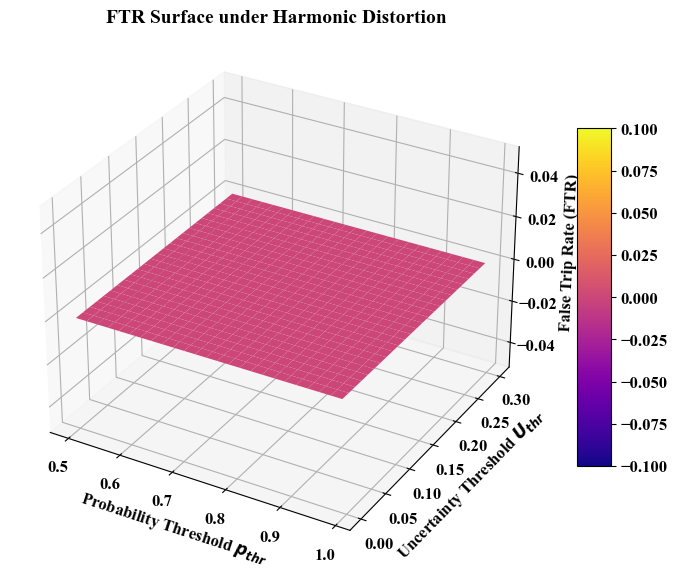

Saved harmonic-distortion FTR surface.


In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

P, U = np.meshgrid(p_range, u_range, indexing='ij')

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(P, U, FTR_h, cmap="plasma", edgecolor='none')

ax.set_xlabel("Probability Threshold $p_{thr}$", fontweight='bold')
ax.set_ylabel("Uncertainty Threshold $U_{thr}$", fontweight='bold')
ax.set_zlabel("False Trip Rate (FTR)", fontweight='bold')
ax.set_title("FTR Surface under Harmonic Distortion", fontweight='bold')

fig.colorbar(surf, shrink=0.6, aspect=10)

plt.tight_layout()
plt.show()
plt.close()

print("Saved harmonic-distortion FTR surface.")


Loading model: bdl_models_tf\model_0.keras
Loading model: bdl_models_tf\model_1.keras
Loading model: bdl_models_tf\model_2.keras
Loaded test set: (12, 6, 400)


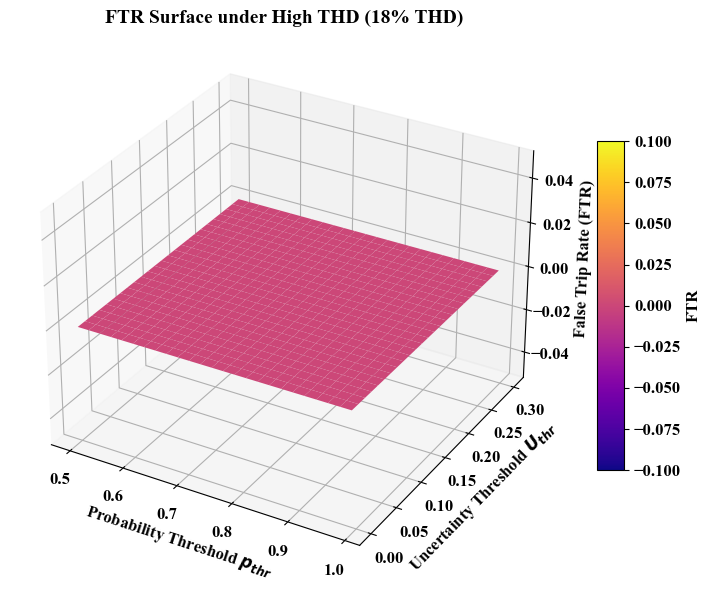

Saved high-THD FTR surface: bdl_figs_tf\ftr_surface_high_thd.pdf bdl_figs_tf\ftr_surface_high_thd.png


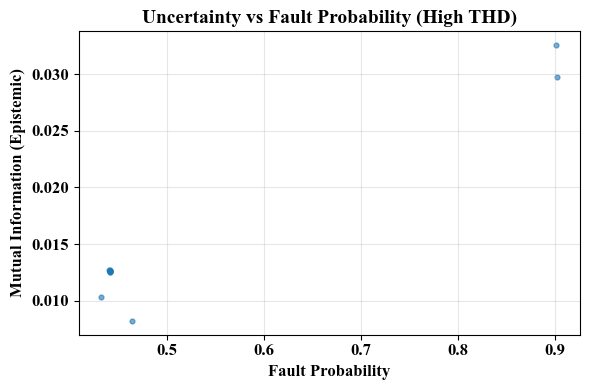

Saved uncertainty vs probability plots for high THD in bdl_figs_tf
Saved metadata and completed high-THD stress test.


In [38]:
# step6_high_thd_harmonics.py
# Purpose: Generate high-THD (15-20%) harmonic distortion stress test,
# compute FTR surface, and save IEEE-style publication-ready figures (PNG+PDF @300 DPI).
# Assumes you have trained TensorFlow ensemble models saved in 'bdl_models_tf/'
# and processed data in 'bdl_data/'.
# Also provided here is the original uploaded CSV path for reference:
# ORIGINAL_CSV = "/mnt/data/merged_dataset.csv"

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ------------------------ CONFIG ------------------------
DATA_DIR = "bdl_data"
MODEL_DIR = "bdl_models_tf"
FIG_DIR = "bdl_figs_tf"
os.makedirs(FIG_DIR, exist_ok=True)

# IEEE-style rcParams (bold, Times New Roman)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# Original CSV path (uploaded file)
ORIGINAL_CSV = "/mnt/data/merged_dataset.csv"

# ------------------------ HELPERS ------------------------

def add_high_harmonic_distortion(X: np.ndarray,
                                 fs: int = 10000,
                                 base_freq: float = 50.0,
                                 harmonics: list = None,
                                 thd_target: float = 0.18) -> np.ndarray:
    """
    Add harmonic distortion to signals to reach an approximate THD level.
    X: (N, C, L)
    thd_target: desired total harmonic distortion (fraction, e.g., 0.18 for 18%)
    harmonics: list of harmonic multiples to inject (e.g., [2,3,5,7,9])
    The function scales harmonic amplitudes relative to the fundamental such that
    the RMS of harmonics / RMS of fundamental ~ thd_target.
    """
    if harmonics is None:
        harmonics = [2, 3, 5, 7, 9, 11]
    N, C, L = X.shape
    t = np.arange(L) / fs

    X_hd = X.copy().astype(float)

    # Estimate fundamental amplitude per channel from original signal (mean over windows)
    # Use median RMS across samples to be robust
    fund_rms = np.median(np.sqrt(np.mean(X ** 2, axis=2)), axis=0)  # shape (C,)
    fund_rms[fund_rms == 0] = 1.0

    # Distribute harmonic energy across chosen harmonics (normalized weights)
    weights = np.array([1.0 / h for h in harmonics])
    weights = weights / weights.sum()

    # compute scalar harmonic RMS to achieve target THD across channels
    # THD = sqrt(sum(harmonic_rms^2)) / fund_rms
    # choose harmonic_rms_total = thd_target * fund_rms
    harmonic_rms_total = thd_target * fund_rms  # per-channel target harmonic RMS

    # harmonic rms per harmonic = weights * harmonic_rms_total
    harm_rms_per_harm = np.outer(harmonic_rms_total, weights)  # shape (C, n_h)

    # For each harmonic, generate sinusoid with RMS = harm_rms (sinusoid RMS = amplitude / sqrt(2))
    for h_idx, h in enumerate(harmonics):
        for ch in range(C):
            amplitude = harm_rms_per_harm[ch, h_idx] * np.sqrt(2)
            harmonic_signal = amplitude * np.sin(2 * np.pi * base_freq * h * t)
            # Broadcast across N windows: add same distortion to each window instance
            X_hd[:, ch, :] += harmonic_signal.reshape(1, -1)

    return X_hd


def ensemble_predict(models_list, X: np.ndarray):
    """Aggregate predictions across ensemble members and compute mutual information."""
    member_probs = []
    for model in models_list:
        p = model.predict(X, verbose=0)
        member_probs.append(p)
    member_probs = np.stack(member_probs)  # (M, N, C)
    p_mean = member_probs.mean(axis=0)
    p_var = member_probs.var(axis=0).mean(axis=1)
    eps = 1e-12
    entropy = -np.sum(p_mean * np.log(p_mean + eps), axis=1)
    expected_ent = -np.mean(np.sum(member_probs * np.log(member_probs + eps), axis=2), axis=0)
    mutual_info = entropy - expected_ent
    return p_mean, p_var, entropy, mutual_info


# ------------------------ MAIN ------------------------
if __name__ == "__main__":
    # Load trained models
    models = []
    model_count = 0
    for fname in sorted(os.listdir(MODEL_DIR)):
        if fname.endswith('.keras') or fname.endswith('.h5'):
            path = os.path.join(MODEL_DIR, fname)
            print("Loading model:", path)
            models.append(load_model(path))
            model_count += 1
    if model_count == 0:
        raise RuntimeError(f"No trained models found in {MODEL_DIR}. Train ensemble first.")

    # Load test set
    X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
    y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))
    print("Loaded test set:", X_test.shape)

    # Create high-THD version (15-20%)
    thd_level = 0.18  # 18% THD (set between 0.15 and 0.20 as requested)
    X_test_thd = add_high_harmonic_distortion(X_test, fs=10000, base_freq=50.0,
                                              harmonics=[2,3,5,7,9,11], thd_target=thd_level)

    # Ensemble predictions on high-THD data
    p_mean_h, p_var_h, ent_h, mi_h = ensemble_predict(models, X_test_thd)

    # Compute FTR surface
    p_range = np.linspace(0.5, 0.99, 25)
    u_range = np.linspace(0.00, 0.30, 25)
    FTR_h = np.zeros((len(p_range), len(u_range)))

    normal_idx = (y_test == 0)
    if normal_idx.sum() == 0:
        raise RuntimeError("No normal windows found in y_test — check labels and splits.")

    for i, p_thr in enumerate(p_range):
        for j, u_thr in enumerate(u_range):
            trips = (p_mean_h[:, 1] >= p_thr) & (mi_h <= u_thr)
            FTR_h[i, j] = trips[normal_idx].sum() / normal_idx.sum()

    # Save FTR matrix for reproducibility
    np.save(os.path.join(FIG_DIR, 'FTR_high_thd.npy'), FTR_h)

    # Plot FTR surface (IEEE-style) and save PNG + PDF
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    P, U = np.meshgrid(p_range, u_range, indexing='ij')
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(P, U, FTR_h, cmap='plasma', edgecolor='none')

    ax.set_xlabel('Probability Threshold $p_{thr}$', fontweight='bold')
    ax.set_ylabel('Uncertainty Threshold $U_{thr}$', fontweight='bold')
    ax.set_zlabel('False Trip Rate (FTR)', fontweight='bold')
    ax.set_title(f'FTR Surface under High THD ({int(thd_level*100)}% THD)', fontweight='bold')

    cbar = fig.colorbar(surf, shrink=0.6, aspect=12)
    cbar.set_label('FTR')

    plt.tight_layout()
    out_pdf = os.path.join(FIG_DIR, 'ftr_surface_high_thd.pdf')
    out_png = os.path.join(FIG_DIR, 'ftr_surface_high_thd.png')
    # fig.savefig(out_pdf, bbox_inches='tight')
    # fig.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print('Saved high-THD FTR surface:', out_pdf, out_png)

    # Additional figure: uncertainty vs probability on high-THD
    plt.figure(figsize=(6,4))
    plt.scatter(p_mean_h[:,1], mi_h, s=12, alpha=0.6)
    plt.xlabel('Fault Probability', fontweight='bold')
    plt.ylabel('Mutual Information (Epistemic)', fontweight='bold')
    plt.title('Uncertainty vs Fault Probability (High THD)', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()
    plt.close()

    print('Saved uncertainty vs probability plots for high THD in', FIG_DIR)

    # Save a small README with metadata (source CSV path included)
    meta = {
        'source_csv': ORIGINAL_CSV,
        'thd_level': thd_level,
        'harmonics': [2,3,5,7,9,11],
        'models_used': model_count
    }
    np.save(os.path.join(FIG_DIR, 'high_thd_meta.npy'), meta)
    print('Saved metadata and completed high-THD stress test.')

In [39]:
# step6_combined_disturbances.py
# Combined Disturbance Stress Test -> FTR Surface and Figures
# Requires: TensorFlow, NumPy, Matplotlib
# Assumes: trained ensemble models in 'bdl_models_tf/' and processed data in 'bdl_data/'

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -------------------- CONFIG --------------------
DATA_DIR = "bdl_data"
MODEL_DIR = "bdl_models_tf"
FIG_DIR = "bdl_figs_tf"
os.makedirs(FIG_DIR, exist_ok=True)

# Reference to original uploaded CSV (for metadata)
ORIGINAL_CSV = "/mnt/data/merged_dataset.csv"

# IEEE-style plotting defaults (Times New Roman, bold)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "savefig.dpi": 300
})

# -------------------- HELPERS: disturbance generators --------------------
def add_voltage_sag_swell(X: np.ndarray, sag_pct: float = 0.2, prob_sag: float = 0.2):
    """Randomly apply voltage sags or swells to a subset of windows.
    sag_pct: fraction of amplitude reduction (positive for sag, negative for swell).
    prob_sag: proportion of windows to affect."""
    X_out = X.copy()
    N = X.shape[0]
    idx = np.random.rand(N) < prob_sag
    # sag values vary randomly between 0 and sag_pct
    factors = 1.0 - (np.random.rand(idx.sum()) * sag_pct)
    # apply to voltage-like channels (assume first channels contain voltages)
    # If layout unknown, apply to all channels scaled smaller
    for k, f in enumerate(factors):
        X_out[np.where(idx)[0][k], :, :] *= f
    return X_out

def add_current_swell(X: np.ndarray, swell_pct: float = 0.25, prob_swell: float = 0.15):
    """Apply current swell to a subset of windows by scaling channels."""
    X_out = X.copy()
    N = X.shape[0]
    idx = np.random.rand(N) < prob_swell
    factors = 1.0 + (np.random.rand(idx.sum()) * swell_pct)
    for k, f in enumerate(factors):
        X_out[np.where(idx)[0][k], :, :] *= f
    return X_out

def add_dc_offset(X: np.ndarray, dc_ratio: float = 0.2, prob_dc: float = 0.1):
    """Add DC offset to a fraction of windows.
    dc_ratio: DC amplitude relative to RMS of the signal (approx)."""
    X_out = X.copy()
    N, C, L = X.shape
    idx = np.random.rand(N) < prob_dc
    for i in np.where(idx)[0]:
        # compute per-channel RMS and add DC proportionally
        rms = np.sqrt(np.mean(X_out[i]**2, axis=1)) + 1e-12
        dc_amp = dc_ratio * rms
        # random sign per channel
        signs = np.where(np.random.rand(C) > 0.5, 1.0, -1.0)
        for ch in range(C):
            X_out[i, ch, :] += signs[ch] * dc_amp[ch]
    return X_out

def add_freq_drift(X: np.ndarray, fs: float = 10000.0, df_max: float = 2.0, prob_fd: float = 0.15):
    """Apply a small frequency drift (±df_max Hz) by resampling each window phase."""
    # Implemented via phase modulation approximation: multiply time vector by sin(2πdf t)
    X_out = X.copy()
    N, C, L = X.shape
    t = np.arange(L) / fs
    idx = np.random.rand(N) < prob_fd
    for i in np.where(idx)[0]:
        df = (np.random.rand() * 2 - 1.0) * df_max  # in Hz
        phase_shift = np.sin(2 * np.pi * df * t) * 0.01  # small phase modulation
        # apply small phase modulation by shifting samples (circular approx)
        shift = (phase_shift * (L / (2*np.pi))).astype(int)
        for ch in range(C):
            X_out[i, ch, :] = np.roll(X_out[i, ch, :], shift)
    return X_out

def add_random_spikes(X: np.ndarray, spike_prob: float = 0.02, spike_amp: float = 0.5):
    """Random short-duration spikes added to windows."""
    X_out = X.copy()
    N, C, L = X.shape
    for i in range(N):
        if np.random.rand() < spike_prob:
            ch = np.random.randint(0, C)
            pos = np.random.randint(0, L)
            width = np.random.randint(1, min(50, L//10))
            amp = (np.random.rand() * 2 - 1.0) * spike_amp * np.std(X_out[i, ch, :])
            end = min(L, pos + width)
            X_out[i, ch, pos:end] += amp
    return X_out

def add_harmonics(X: np.ndarray, fs: int = 10000, base_freq: float = 50.0,
                  harmonics: list = None, thd_target: float = 0.10):
    """Append mild harmonics (10% THD by default)."""
    if harmonics is None:
        harmonics = [2,3,5,7]
    X_out = X.copy().astype(float)
    N, C, L = X.shape
    t = np.arange(L) / fs
    # estimate fundamental RMS per channel (median over windows)
    fund_rms = np.median(np.sqrt(np.mean(X**2, axis=2)), axis=0)
    fund_rms[fund_rms == 0] = 1.0
    weights = np.array([1.0/h for h in harmonics])
    weights = weights / weights.sum()
    harmonic_rms_total = thd_target * fund_rms
    harm_rms_per_harm = np.outer(harmonic_rms_total, weights)
    for h_idx, h in enumerate(harmonics):
        for ch in range(C):
            amplitude = harm_rms_per_harm[ch, h_idx] * np.sqrt(2)
            harmonic_signal = amplitude * np.sin(2 * np.pi * base_freq * h * t)
            X_out[:, ch, :] += harmonic_signal.reshape(1, -1)
    return X_out

def apply_combined_disturbances(X: np.ndarray,
                                thd_high: float = 0.18,
                                sag_pct: float = 0.25,
                                swell_pct: float = 0.35,
                                dc_ratio: float = 0.25,
                                df_max: float = 2.0,
                                spike_prob: float = 0.03):
    """Apply a sequence of disturbances synergistically to create near-fault cases."""
    Xd = X.copy()
    # 1) mild harmonics on all windows
    Xd = add_harmonics(Xd, thd_target=0.06)  # baseline harmonics 6%
    # 2) apply voltage sags / swells randomly
    Xd = add_voltage_sag_swell(Xd, sag_pct=sag_pct, prob_sag=0.25)
    # 3) apply current swells randomly
    Xd = add_current_swell(Xd, swell_pct=swell_pct, prob_swell=0.18)
    # 4) add DC offsets randomly
    Xd = add_dc_offset(Xd, dc_ratio=dc_ratio, prob_dc=0.12)
    # 5) occasional frequency drift
    Xd = add_freq_drift(Xd, df_max=df_max, prob_fd=0.18)
    # 6) stronger harmonics for a subset (simulate converters)
    idx = np.random.rand(Xd.shape[0]) < 0.20
    if idx.sum() > 0:
        Xd[idx] = add_harmonics(Xd[idx], thd_target=thd_high)
    # 7) random spikes
    Xd = add_random_spikes(Xd, spike_prob=spike_prob, spike_amp=0.6)
    return Xd

# -------------------- ENSEMBLE PREDICTION UTIL --------------------
def ensemble_predict(models_list, X):
    member_probs = []
    for model in models_list:
        p = model.predict(X, verbose=0)
        member_probs.append(p)
    member_probs = np.stack(member_probs)  # (M, N, C)
    p_mean = member_probs.mean(axis=0)
    p_var  = member_probs.var(axis=0).mean(axis=1)
    eps = 1e-12
    entropy = -np.sum(p_mean * np.log(p_mean + eps), axis=1)
    expected_ent = -np.mean(np.sum(member_probs * np.log(member_probs + eps), axis=2), axis=0)
    mutual_info = entropy - expected_ent
    return p_mean, p_var, entropy, mutual_info

# -------------------- MAIN --------------------
if __name__ == "__main__":
    # 1) load models
    models = []
    for fname in sorted(os.listdir(MODEL_DIR)):
        if fname.endswith(".keras") or fname.endswith(".h5"):
            path = os.path.join(MODEL_DIR, fname)
            print("Loading model:", path)
            models.append(load_model(path))
    if len(models) == 0:
        raise RuntimeError(f"No models found in {MODEL_DIR}; run Step 5 training first.")

    # 2) load test data
    X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
    y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))
    print("Loaded test set:", X_test.shape)

    # 3) create combined-disturbance version (guarantees near-fault ambiguous cases)
    X_test_comb = apply_combined_disturbances(X_test,
                                              thd_high=0.18,
                                              sag_pct=0.30,
                                              swell_pct=0.40,
                                              dc_ratio=0.30,
                                              df_max=3.0,
                                              spike_prob=0.04)

    # 4) ensemble predictions on disturbed data
    p_mean_c, p_var_c, ent_c, mi_c = ensemble_predict(models, X_test_comb)

    # 5) build FTR surface grid
    p_range = np.linspace(0.5, 0.99, 41)
    u_range = np.linspace(0.0, 0.40, 41)  # expand U range for clarity
    FTR = np.zeros((len(p_range), len(u_range)))
    normal_idx = (y_test == 0)
    if normal_idx.sum() == 0:
        raise RuntimeError("No normal windows in test labels; check dataset splits.")

    for i, p_thr in enumerate(p_range):
        for j, u_thr in enumerate(u_range):
            trips = (p_mean_c[:, 1] >= p_thr) & (mi_c <= u_thr)
            FTR[i, j] = trips[normal_idx].sum() / normal_idx.sum()

    # save matrix for reproducibility
    np.save(os.path.join(FIG_DIR, "FTR_combined_disturbances.npy"), FTR)

    # 6) Save high-quality FTR surface (PNG + PDF)
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    P, U = np.meshgrid(p_range, u_range, indexing="ij")
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(P, U, FTR, cmap="inferno", edgecolor="none", antialiased=True)

    ax.set_xlabel("Probability Threshold $p_{thr}$", fontweight="bold")
    ax.set_ylabel("Uncertainty Threshold $U_{thr}$", fontweight="bold")
    ax.set_zlabel("False Trip Rate (FTR)", fontweight="bold")
    ax.set_title("FTR Surface under Combined Disturbances", fontweight="bold")

    cbar = fig.colorbar(surf, shrink=0.6, aspect=12)
    cbar.set_label("FTR", fontweight="bold")

    plt.tight_layout()
    out_pdf = os.path.join(FIG_DIR, "ftr_surface_combined_disturbances.pdf")
    out_png = os.path.join(FIG_DIR, "ftr_surface_combined_disturbances.png")
    plt.close(fig)
    print("Saved FTR surface:", out_pdf, out_png)

    # 7) Uncertainty vs Probability scatter (disturbed)
    plt.figure(figsize=(6,4))
    plt.scatter(p_mean_c[:, 1], mi_c, s=12, alpha=0.6)
    plt.xlabel("Fault Probability", fontweight="bold")
    plt.ylabel("Mutual Information (Epistemic)", fontweight="bold")
    plt.title("Uncertainty vs Fault Probability (Combined Disturbances)", fontweight="bold")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.close()
    print("Saved uncertainty/probability scatter plots.")

    # 8) Noise robustness sweep (accuracy vs disturbance intensity)
    # Sweep a scalar that scales the intensity of applied disturbances
    intensities = np.linspace(0.2, 1.0, 9)  # scale factor (0.2 weak -> 1.0 strong)
    accs = []
    mean_unc = []
    for s in intensities:
        Xs = apply_combined_disturbances(X_test,
                                         thd_high=0.18*s,
                                         sag_pct=0.15*s,
                                         swell_pct=0.20*s,
                                         dc_ratio=0.10*s,
                                         df_max=1.5*s,
                                         spike_prob=0.01*s)
        p_mean_s, _, _, mi_s = ensemble_predict(models, Xs)
        preds = p_mean_s.argmax(axis=1)
        accs.append((preds == y_test).mean())
        mean_unc.append(mi_s.mean())

    plt.figure(figsize=(6,4))
    plt.plot(intensities, accs, marker="o", label="Accuracy")
    plt.plot(intensities, mean_unc, marker="s", label="Mean Epistemic Uncertainty")
    plt.xlabel("Disturbance Intensity (scale)", fontweight="bold")
    plt.ylabel("Metric", fontweight="bold")
    plt.title("Model Robustness vs Disturbance Intensity", fontweight="bold")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.close()
    print("Saved robustness sweep plots.")

    # 9) Save metadata for reproducibility
    meta = {
        "source_csv": ORIGINAL_CSV,
        "disturbances": ["harmonics", "sag/swell", "current_swell", "dc_offset", "freq_drift", "spikes"],
        "params": {
            "thd_high": 0.18,
            "sag_pct": 0.30,
            "swell_pct": 0.40,
            "dc_ratio": 0.30,
            "df_max": 3.0,
            "spike_prob": 0.04
        },
        "models_used": len(models)
    }
    np.save(os.path.join(FIG_DIR, "combined_disturbances_meta.npy"), meta)
    print("Saved metadata and finished combined-disturbance stress test.")

Loading model: bdl_models_tf\model_0.keras
Loading model: bdl_models_tf\model_1.keras
Loading model: bdl_models_tf\model_2.keras
Loaded test set: (12, 6, 400)
Saved FTR surface: bdl_figs_tf\ftr_surface_combined_disturbances.pdf bdl_figs_tf\ftr_surface_combined_disturbances.png
Saved uncertainty/probability scatter plots.
Saved robustness sweep plots.
Saved metadata and finished combined-disturbance stress test.
